




#  SAM -> CLIP (OPEN CLIP) 

## Preparation for colab

In [1]:
import cv2
import os
import numpy as np
import torch
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import OrderedDict
import torch
from open_clip import tokenizer

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



d:\ProgramData\anaconda3\envs\Sam_alpha_clip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_

In [4]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
preprocess

d:\ProgramData\anaconda3\envs\Sam_alpha_clip\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mm\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x000001EADC953280>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408


# Setting up input texts

We are going to feed images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

The image class we want are:
We use a LLM model help us to generate description text for the class, using the fllowing prompt:
Help me to generate a line of visual desciption of  {ripe strawberry fruit} that should be distinguishable from
{unripe strawberry fruit,  leaves,  stem, strawberry flower,  background} in {strawberry cultivation} environment.

In [6]:
# NOT IN USE!
# images in skimage to use and their textual descriptions
descriptions = {
"ripe strawberry fruit": "A ripe strawberry fruit in a cultivation environment gleams with a lush deep red hue its surface dotted with tiny golden seeds contrasting vividly against the unripe berries' green blush the verdant leaves' broad embrace the slender green stems and the delicate white petals of the strawberry flowers amidst the earthy tones of the background.",
"unripe strawberry fruit": "An unripe strawberry fruit in the midst of cultivation shyly hints at potential its surface a pale green canvas slowly surrendering to blushes of red starkly distinct from the deep ruby luster of ripe berries the sprawling verdancy of leaves the slender elegance of stems the delicate white and yellow of strawberry flowers and the rich nurturing earth that forms the background tapestry.",
"leaves": "In the strawberry cultivation milieu the leaves present themselves as vibrant green fans their robust serrated edges and veiny textures standing out against the delicate green-to-red transition of unripe fruits the rich crimson of ripe berries the slender supportive grace of the stems the gentle allure of white and yellow strawberry flowers and the subdued earth tones that cradle this dance of growth beneath them.",
"stem": "Within the bustling scene of strawberry cultivation the stem asserts its presence as a slender thread of vitality its green hue subtly lighter than the leaves gracefully arching to support both the hopeful promise of unripe berries and the succulent weight of ripe fruits distinctly set apart from the leafy canopy above the enchanting blooms of strawberry flowers and the nurturing muted backdrop of the cultivated earth below.",
"strawberry flower": "Amidst the verdant sprawl of strawberry cultivation the strawberry flower emerges as a beacon of delicate beauty its pristine white petals radiating outward from a soft yellow center a stark contrast to the dense greenery of leaves the subtle green to passionate red gradation of the fruits the unassuming green lines of the stems and the earthy unobtrusive canvas of the background marking the genesis of future sweetness in the garden's cycle of growth.",
"background": "In the tableau of strawberry cultivation the background melds into a harmonious tapestry of rich fertile soil tones its understated mosaic of browns and earthen textures quietly supportive a grounding contrast to the vivid dance of life above— from the subtle hues of unripe berries to the vibrant red of ripeness the slender reaching lines of stems the lush green expanse of leaves and the gentle white purity of strawberry flowers all playing out their roles on this natural stage."
}

In [7]:

def mask_image(image, mask):
    """Masks an image with a binary mask, retaining color in the masked area and setting
       the rest to white.

    Args:
        image: The input image as a NumPy array.
        mask: The binary mask as a NumPy array, where 255 represents the masked area.

    Returns:
        The masked image as a NumPy array.
    """

    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image[mask == 0] = 255  # Set unmasked areas to white
    return masked_image

def crop_object_from_white_background(image):
   """Crops an image with a white background to the minimal bounding box containing a non-white object.
   """

   img = Image.fromarray(image)

   # Load the image
   img_array = np.array(image)

   # Find non-white pixels
   non_white_mask = np.any(img_array != 255, axis=2)  # Check all color channels

   # Find bounding box coordinates
   ymin, xmin = np.where(non_white_mask)[0].min(), np.where(non_white_mask)[1].min()
   ymax, xmax = np.where(non_white_mask)[0].max() + 1, np.where(non_white_mask)[1].max() + 1

   # Crop the image
   cropped_img = img.crop((xmin, ymin, xmax, ymax))

   return cropped_img

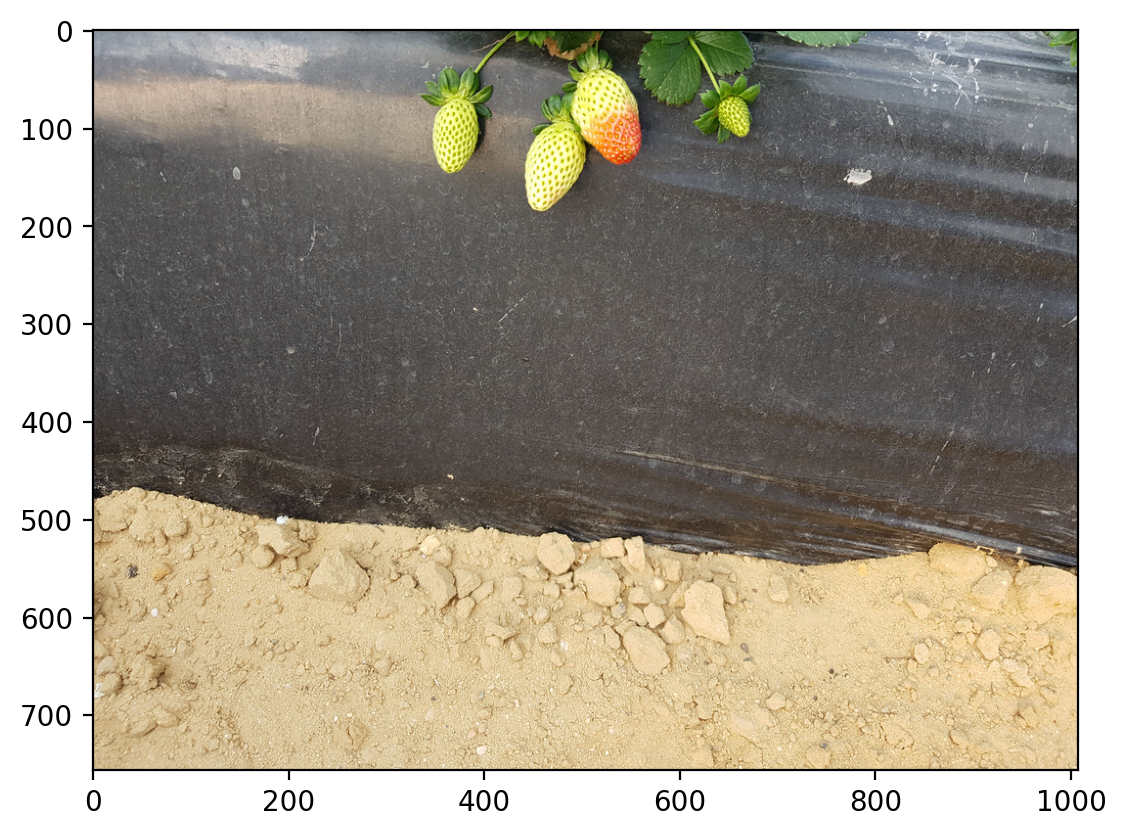

In [8]:
# image segs folder
image_segs_folder = "../examples/strawberry/1"
rgb_image = cv2.cvtColor(cv2.imread(image_segs_folder + "/1.png"), cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)


In [9]:
def get_masked_image(image_segs_folder, mask_id):
    mask_img_path = image_segs_folder + "/mask_%i.png"%mask_id
    mask_img = cv2.imread(mask_img_path)[:, :, 0] # only one layer mask is needed
    print("mask_img_path: ", mask_img_path)
    masked_image = mask_image(rgb_image, mask_img)
    return masked_image

mask_img_path:  ../examples/strawberry/1/mask_16.png
mask_img_path:  ../examples/strawberry/1/mask_50.png
mask_img_path:  ../examples/strawberry/1/mask_45.png
mask_img_path:  ../examples/strawberry/1/mask_45.png
mask_img_path:  ../examples/strawberry/1/mask_44.png
mask_img_path:  ../examples/strawberry/1/mask_70.png
mask_img_path:  ../examples/strawberry/1/mask_58.png
mask_img_path:  ../examples/strawberry/1/mask_28.png


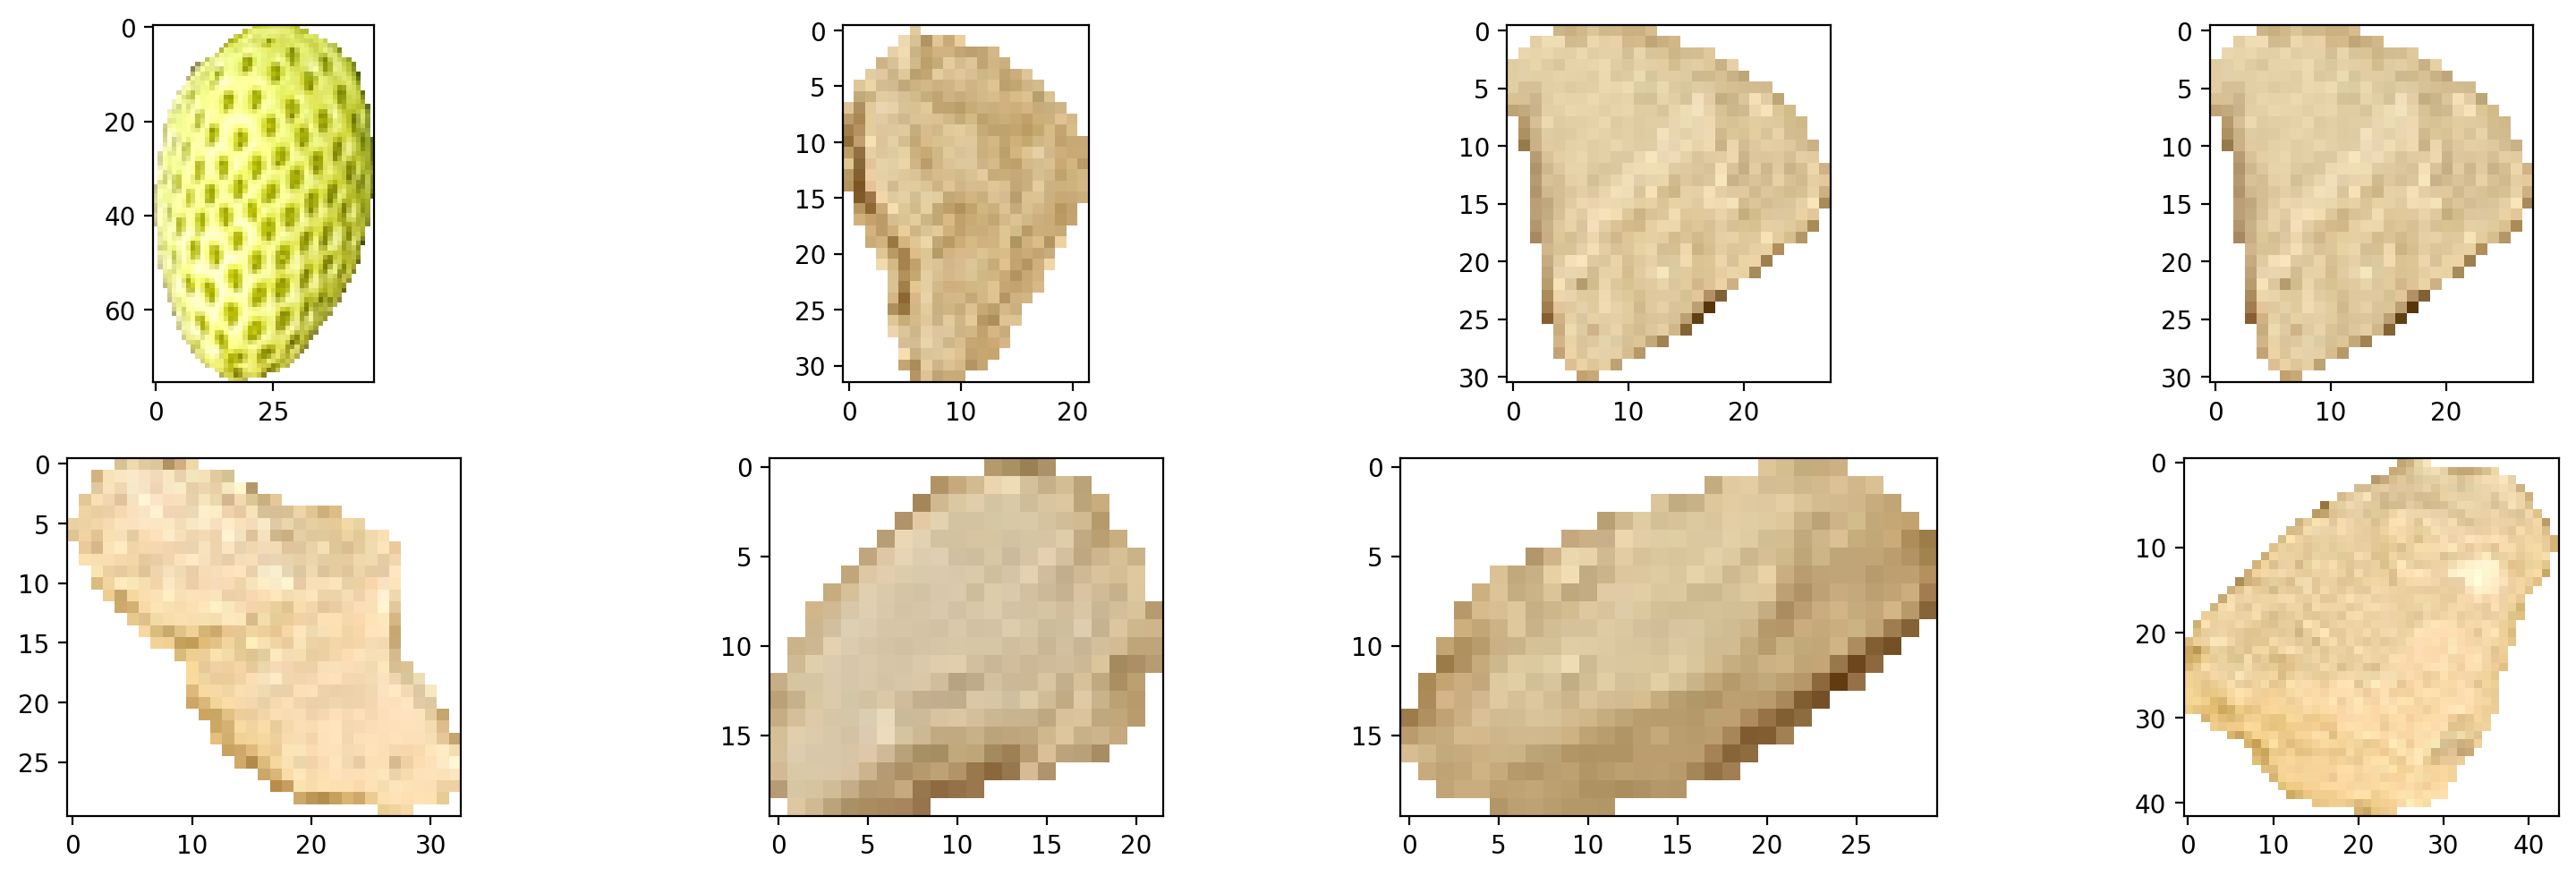

In [10]:

original_images = []
images = []
plt.figure(figsize=(16, 5))
mask_ids = [random.randint(0, 100) for _ in range(8)]
for i, mask_id in enumerate(mask_ids):
    masked_image = get_masked_image(image_segs_folder, mask_id)
    image = crop_object_from_white_background(masked_image)

    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    original_images.append(image)
    images.append(preprocess(image))

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [11]:
texts = {
"ripe strawberry fruit. A ripe strawberry fruit in a cultivation environment gleams with a lush deep red hue its surface dotted with tiny golden seeds contrasting vividly against the unripe berries' green blush the verdant leaves' broad embrace the slender green stems and the delicate white petals of the strawberry flowers amidst the earthy tones of the background.",
"unripe strawberry fruit. An unripe strawberry fruit in the midst of cultivation shyly hints at potential its surface a pale green canvas slowly surrendering to blushes of red starkly distinct from the deep ruby luster of ripe berries the sprawling verdancy of leaves the slender elegance of stems the delicate white and yellow of strawberry flowers and the rich nurturing earth that forms the background tapestry.",
"leaves. In the strawberry cultivation milieu the leaves present themselves as vibrant green fans their robust serrated edges and veiny textures standing out against the delicate green-to-red transition of unripe fruits the rich crimson of ripe berries the slender supportive grace of the stems the gentle allure of white and yellow strawberry flowers and the subdued earth tones that cradle this dance of growth beneath them.",
"stem. Within the bustling scene of strawberry cultivation the stem asserts its presence as a slender thread of vitality its green hue subtly lighter than the leaves gracefully arching to support both the hopeful promise of unripe berries and the succulent weight of ripe fruits distinctly set apart from the leafy canopy above the enchanting blooms of strawberry flowers and the nurturing muted backdrop of the cultivated earth below.",
"strawberry flower. Amidst the verdant sprawl of strawberry cultivation the strawberry flower emerges as a beacon of delicate beauty its pristine white petals radiating outward from a soft yellow center a stark contrast to the dense greenery of leaves the subtle green to passionate red gradation of the fruits the unassuming green lines of the stems and the earthy unobtrusive canvas of the background marking the genesis of future sweetness in the garden's cycle of growth.",
"background. In the tableau of strawberry cultivation the background melds into a harmonious tapestry of rich fertile soil tones its understated mosaic of browns and earthen textures quietly supportive a grounding contrast to the vivid dance of life above— from the subtle hues of unripe berries to the vibrant red of ripeness the slender reaching lines of stems the lush green expanse of leaves and the gentle white purity of strawberry flowers all playing out their roles on this natural stage."
}


In [12]:
texts = [
"strawberry",
"leaves, leaf",
"stem",
"flower",
"others, brown soil, black plastic"
]
print(texts)

['strawberry', 'leaves, leaf', 'stem', 'flower', 'others, brown soil, black plastic']


In [13]:
text_tokens = tokenizer.tokenize(["This is " + desc for desc in texts])


In [14]:
image_input = torch.tensor(np.stack(images))


In [15]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [16]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

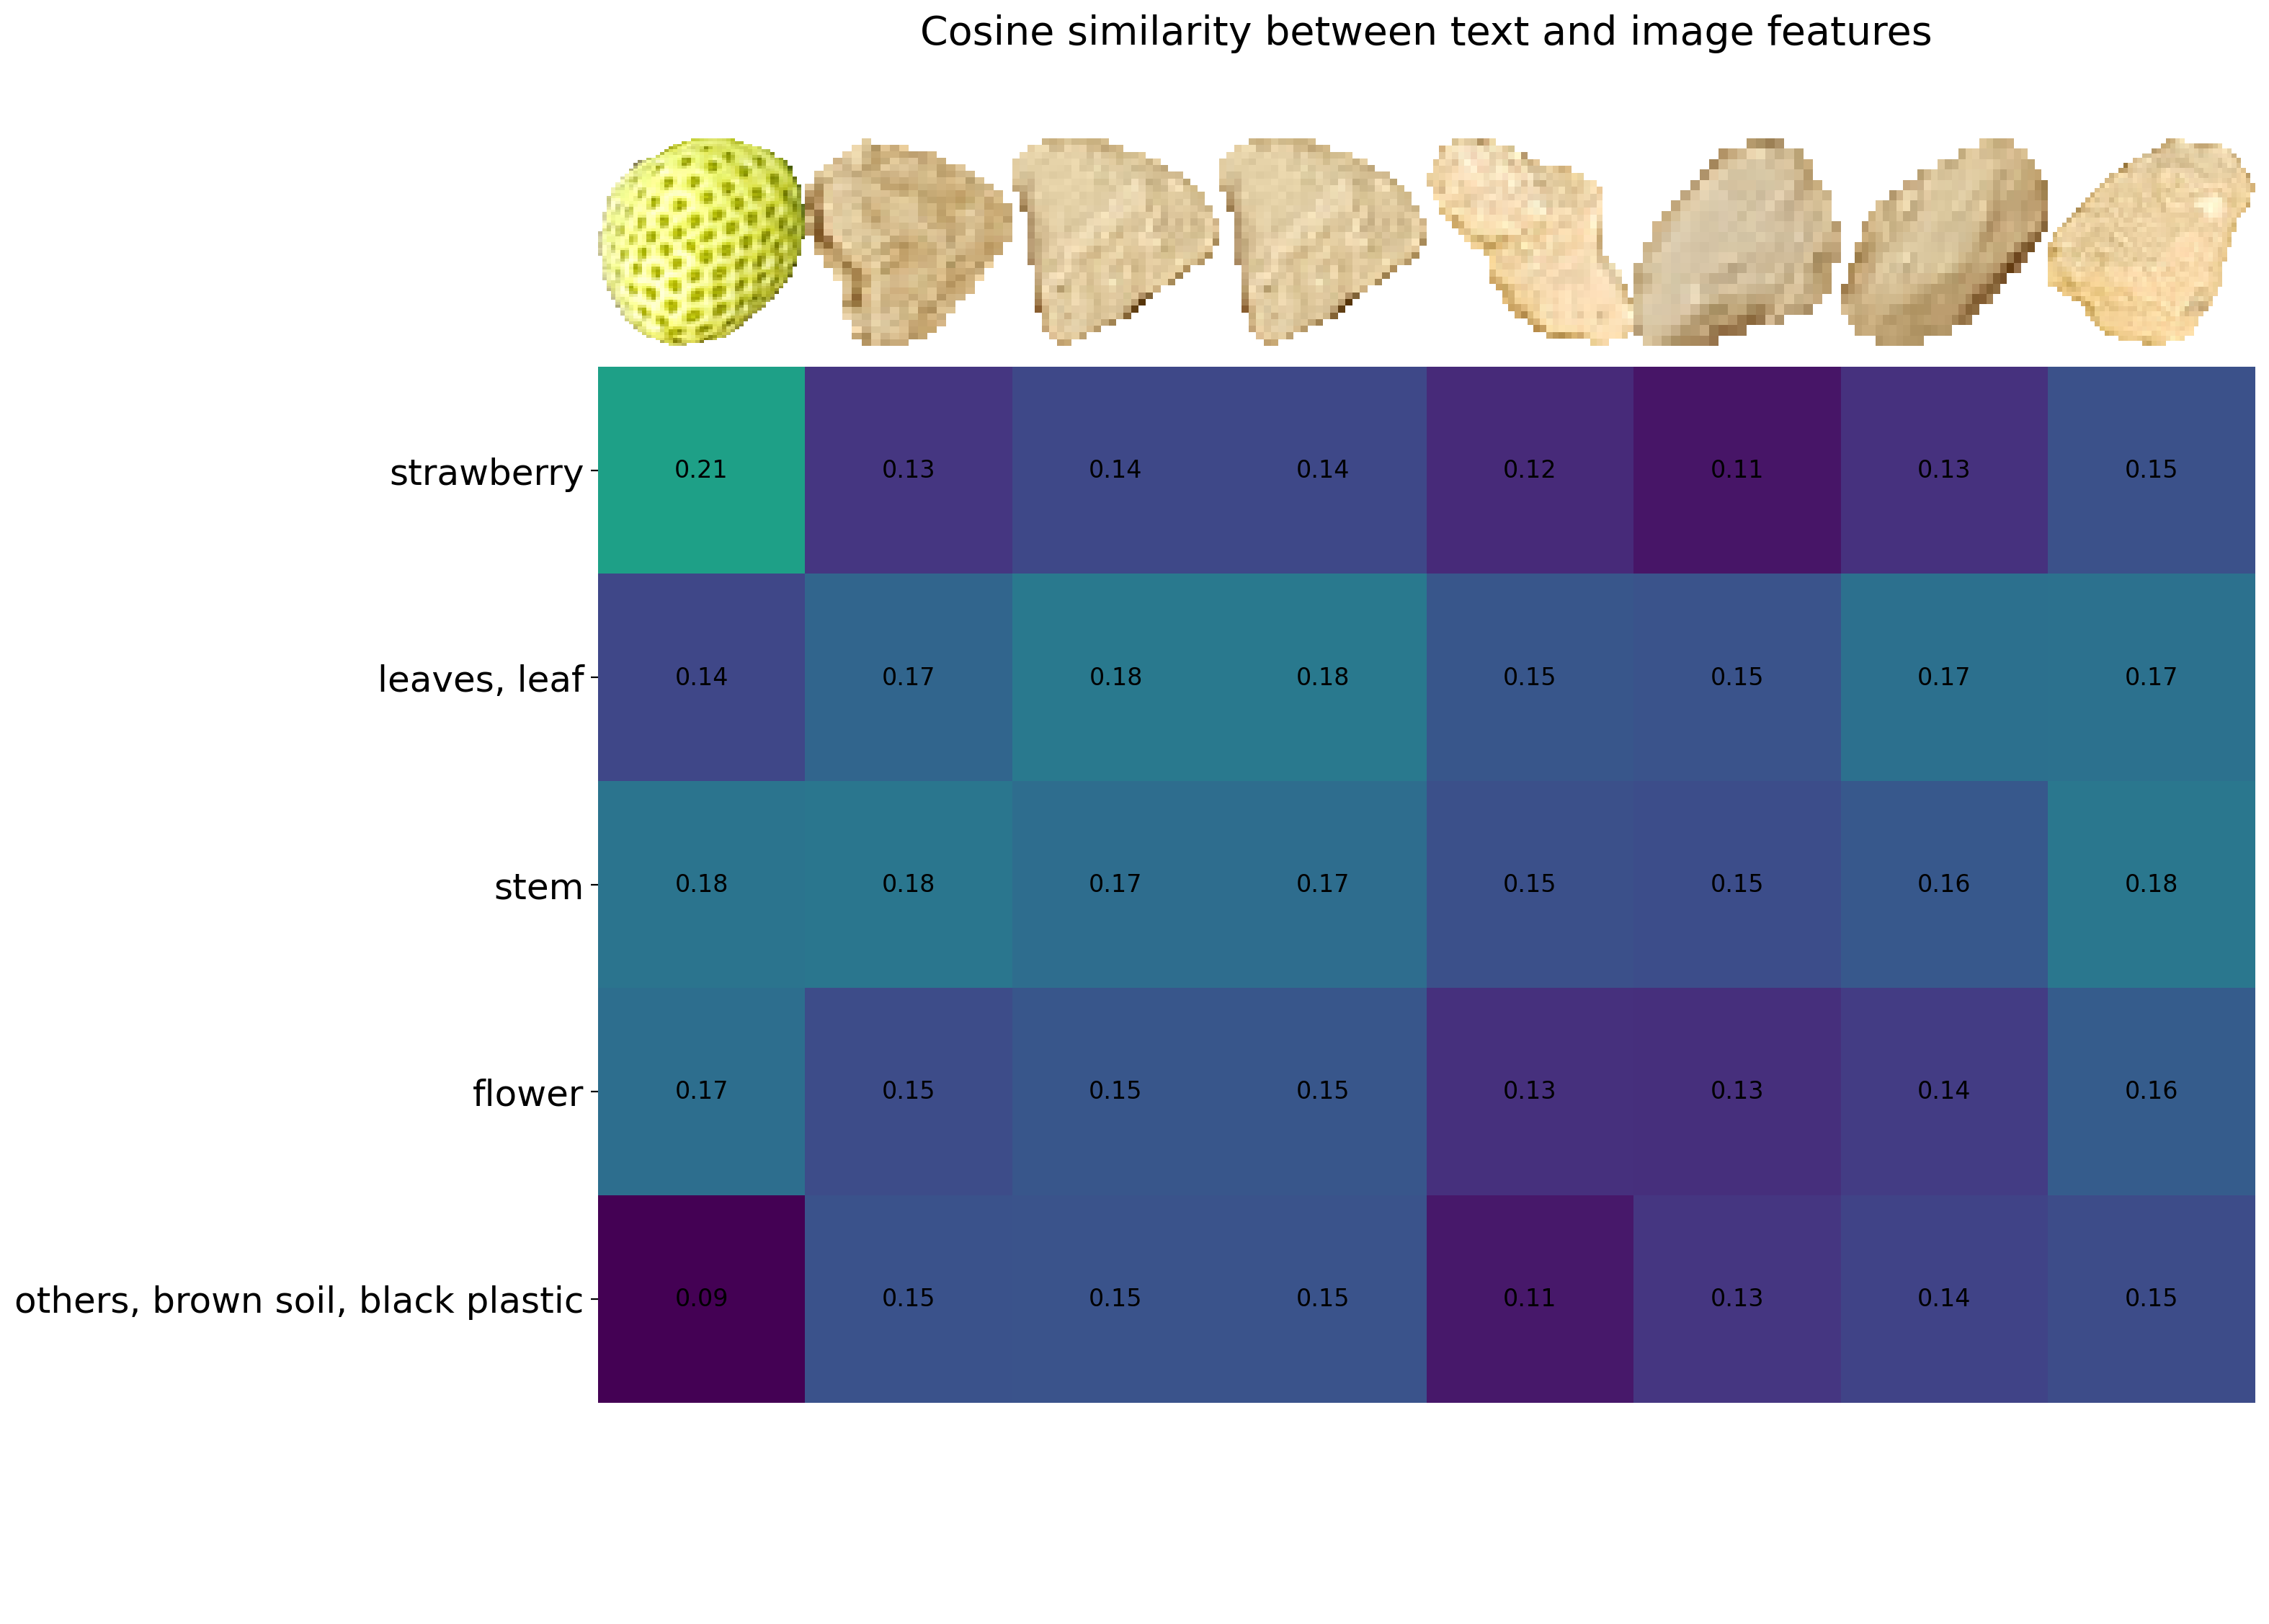

In [17]:
count = len(texts)

plt.figure(figsize=(25, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(original_images) - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [18]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [01:34<00:00, 1785779.18it/s]


Extracting C:\Users\mm/.cache\cifar-100-python.tar.gz to C:\Users\mm/.cache


In [19]:
text_descriptions = [f"A photo of a {label}" for label in cifar100.classes]
text_tokens = tokenizer.tokenize(text_descriptions)

In [20]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

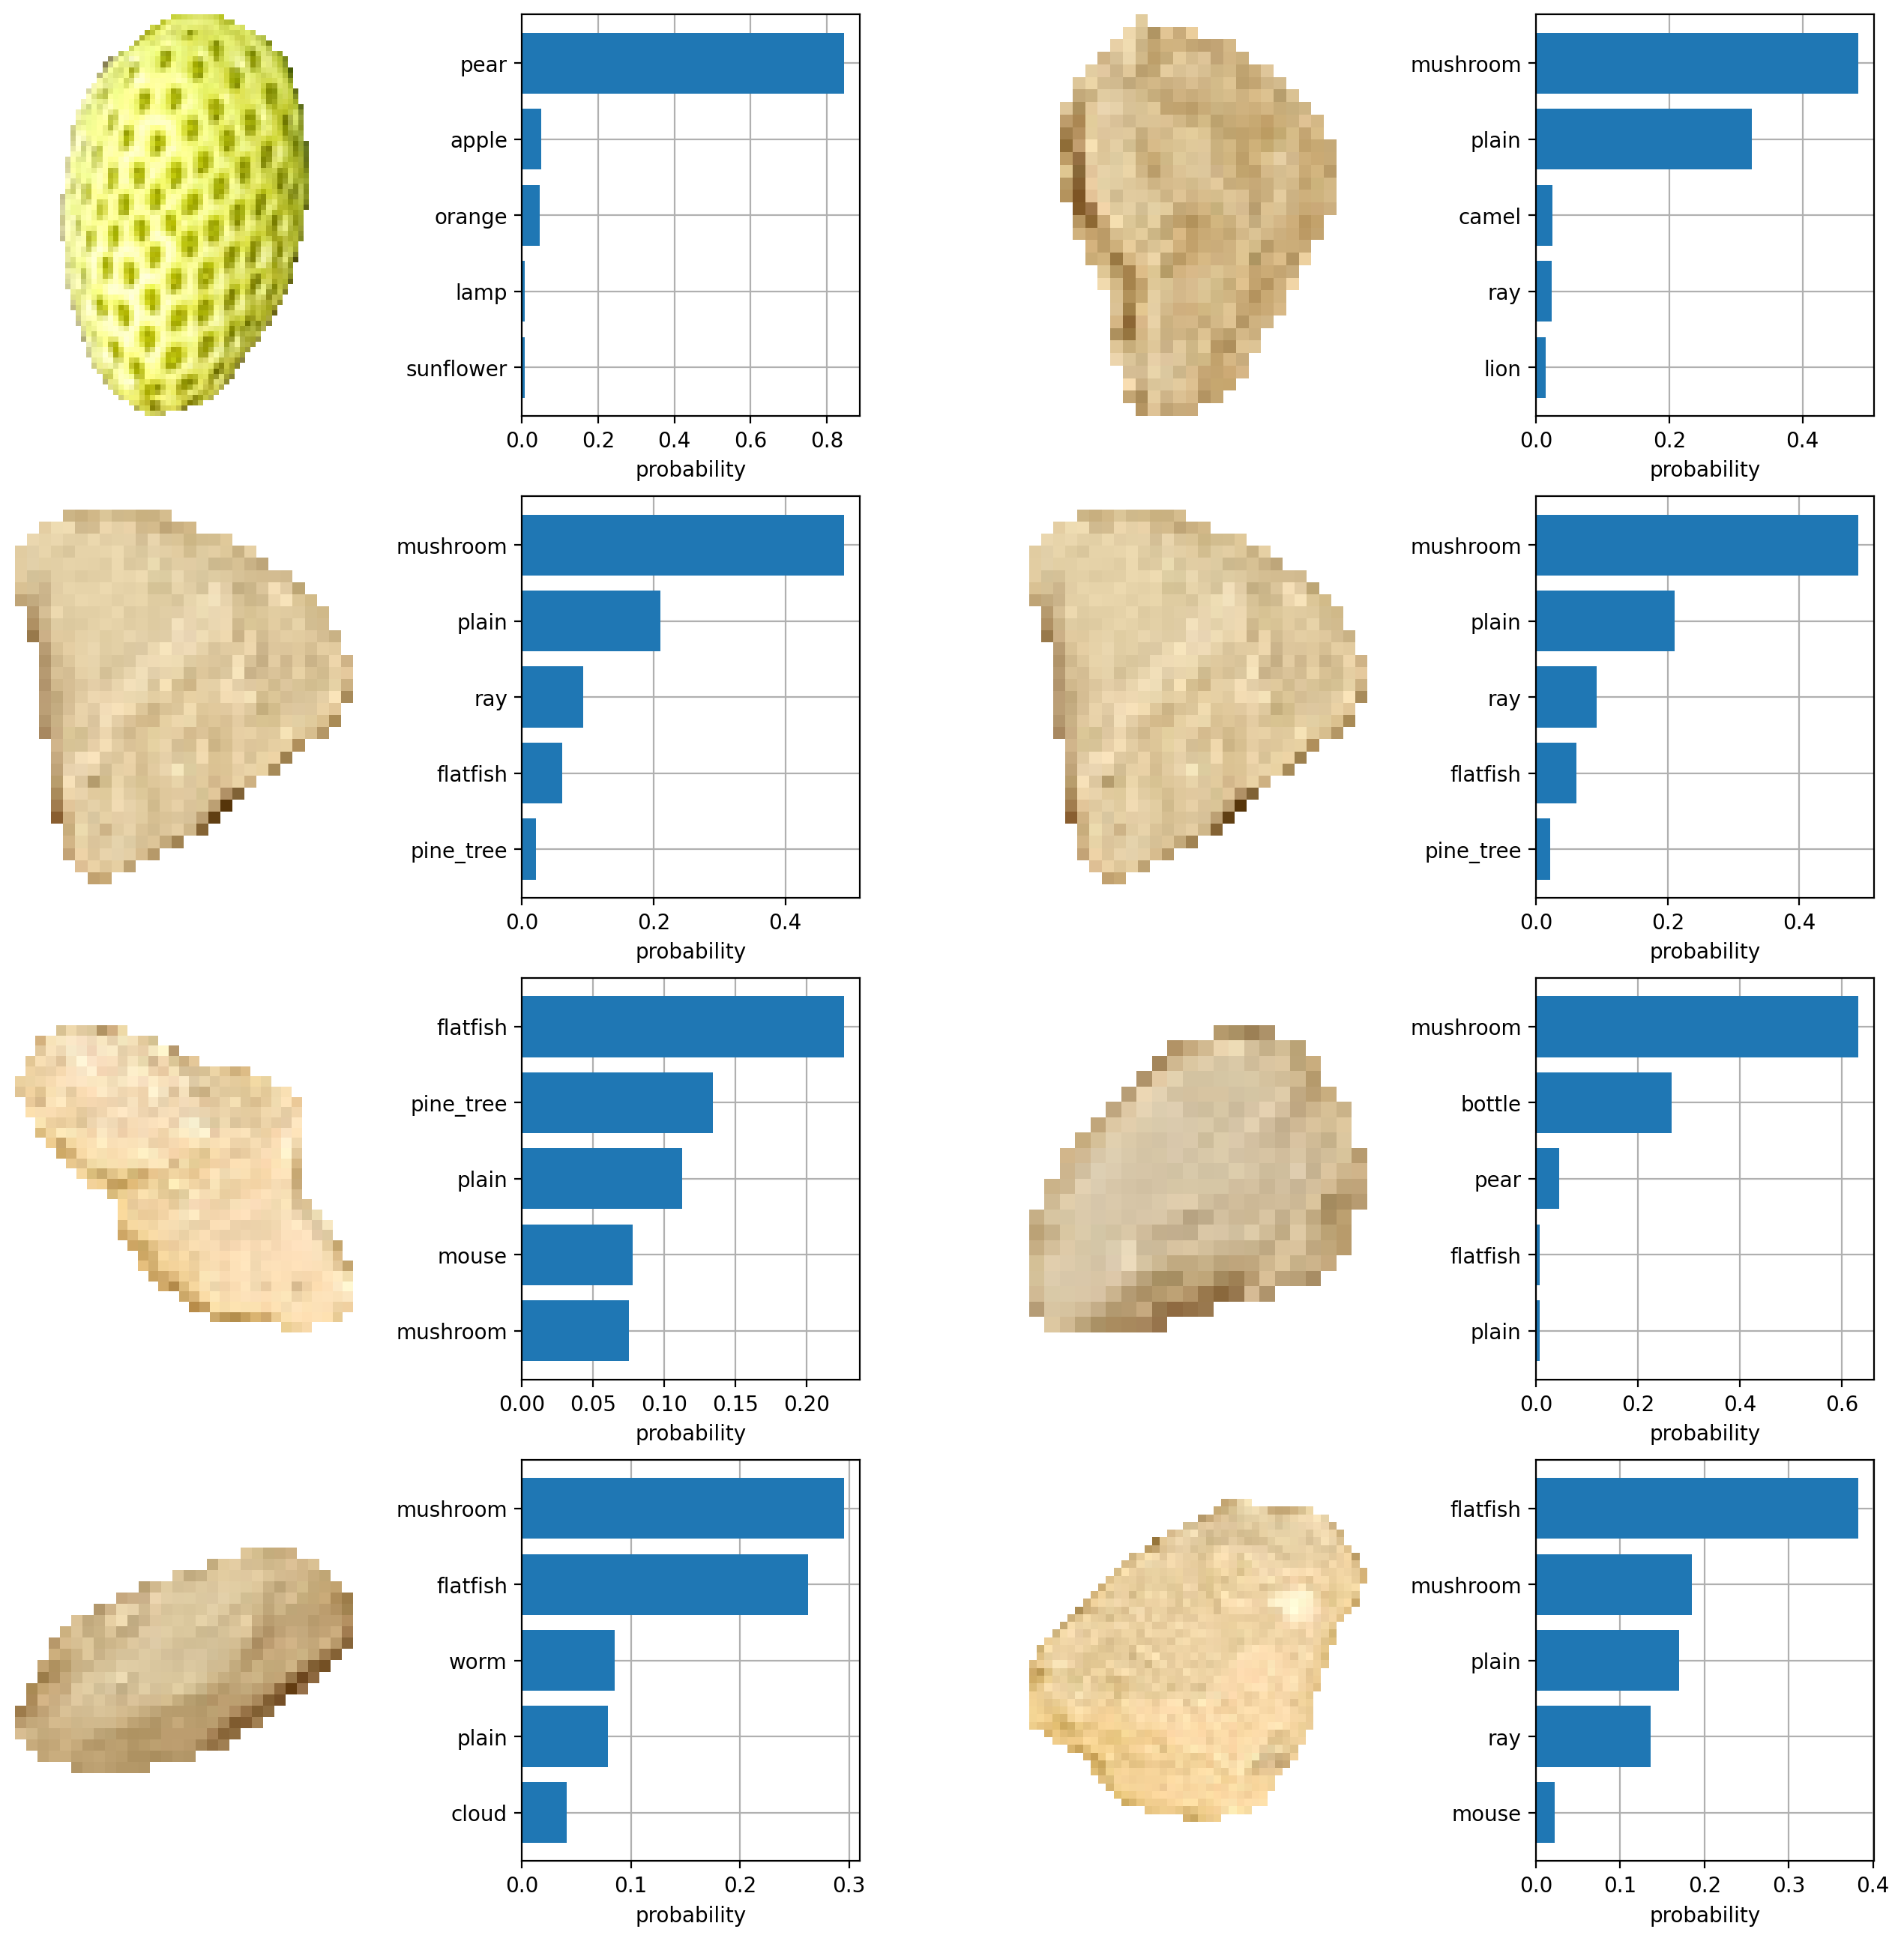

In [21]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()